# Prédiction de Salaires - Régression Linéaire Multiple

## Objectif
Ce notebook présente une analyse complète de régression linéaire multiple pour prédire les salaires des employés.

## Plan d'analyse
1. **Exploration des données**
2. **Préparation des données**
3. **Modélisation**
   - Baseline avec DummyRegressor
   - Régression linéaire simple
4. **Réugularisation avec GridSearchCV**
   - Ridge Regression (L2)
   - Lasso Regression (L1)
6. **Résumé et Comparaison Finale**

In [1]:
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Chargement et Exploration des Données

In [27]:
# Chargement des données

# TO DO : Charger le dataset employee_salaries.csv dans un DataFrame pandas et afficher les 5 premières lignes ainsi que la shape du dataset
data = pd.read_csv('data/employee_salaries.csv')
df = pd.DataFrame(data)
print(df.shape) 
df.head(5)


(10000, 14)


,age,experience,education_years,heures_semaine,nb_projets,evaluation_performance,anciennete_entreprise,niveau_education,departement,poste,ville,secteur,taille_entreprise,salaire_annuel
0,38,5,0,39,3.0,2.9,2,Bac,Marketing,Senior,Paris,Services,Grande Entreprise,95600.0
1,29,0,1,35,1.0,4.6,0,Bac,Finance,Junior,Paris,Services,ETI,41500.0
2,25,1,0,37,0.0,4.4,0,Bac,R&D,Junior,Autres,Santé,Grande Entreprise,44300.0
3,25,1,4,40,3.0,7.4,0,Master,Ventes,Junior,Toulouse,Services,ETI,57100.0
4,37,5,1,41,7.0,5.0,0,Bac,IT,Senior,Paris,Tech,ETI,128000.0


In [25]:
# Informations sur le dataset et statistiques descriptives

# TO DO : Afficher les informations statistiques sur le dataset ainsi que le nombre de valeurs manquantes par colonne
print(df.isnull().sum())
df.info()


age                         0
experience                  0
education_years             0
heures_semaine              0
nb_projets                100
evaluation_performance    200
anciennete_entreprise       0
niveau_education            0
departement                 0
poste                       0
ville                       0
secteur                     0
taille_entreprise           0
salaire_annuel              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   experience              10000 non-null  int64  
 2   education_years         10000 non-null  int64  
 3   heures_semaine          10000 non-null  int64  
 4   nb_projets              9900 non-null   float64
 5   evaluation_performance  9800 non-null   float64
 6   anciennete_entreprise   10000 

In [26]:
# Séparation des variables numériques et catégorielles

# Utiliser select_dtypes pour créer deux listes : numeric_cols et categorical_cols
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Optionnel : sélectionner explicitement object/category/bool comme catégorielles
# categorical_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

print(f"Numeric columns ({len(numeric_cols)}):", numeric_cols)
print(f"Categorical columns ({len(categorical_cols)}):", categorical_cols)

Numeric columns (8): ['age', 'experience', 'education_years', 'heures_semaine', 'nb_projets', 'evaluation_performance', 'anciennete_entreprise', 'salaire_annuel']
Categorical columns (6): ['niveau_education', 'departement', 'poste', 'ville', 'secteur', 'taille_entreprise']


<Figure size 1200x800 with 0 Axes>

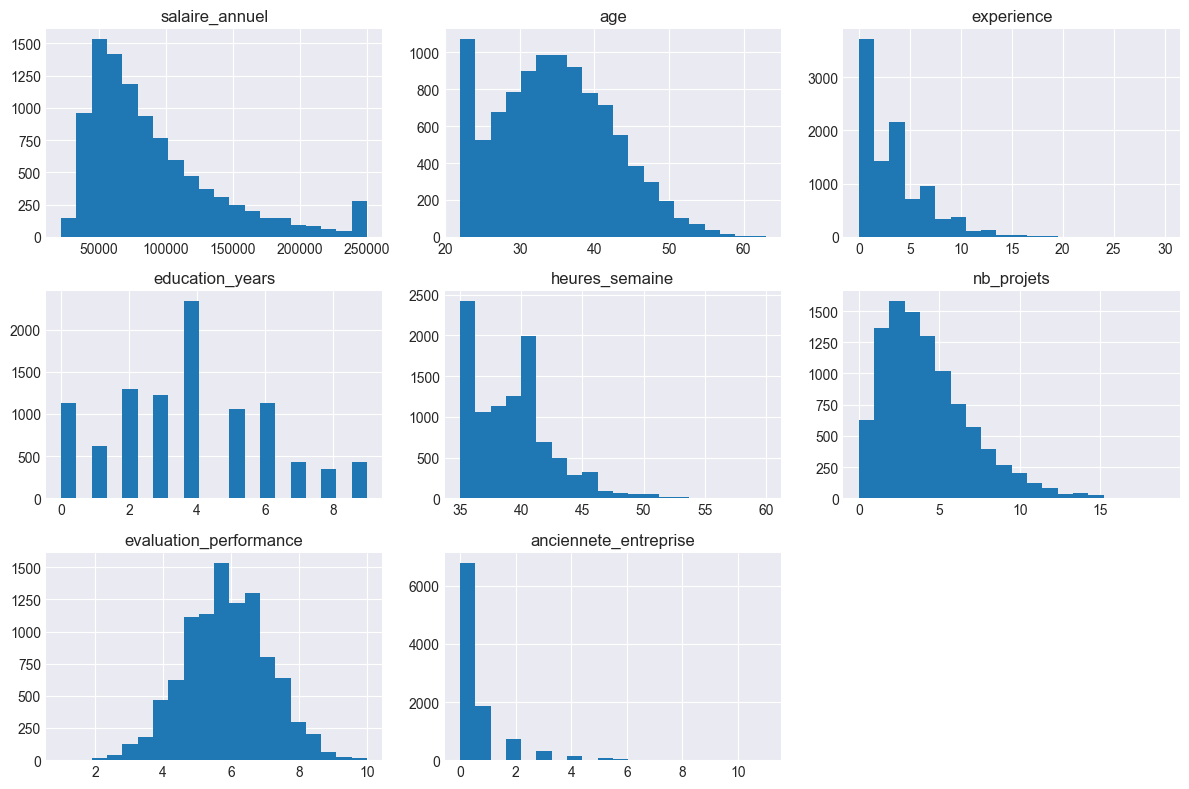

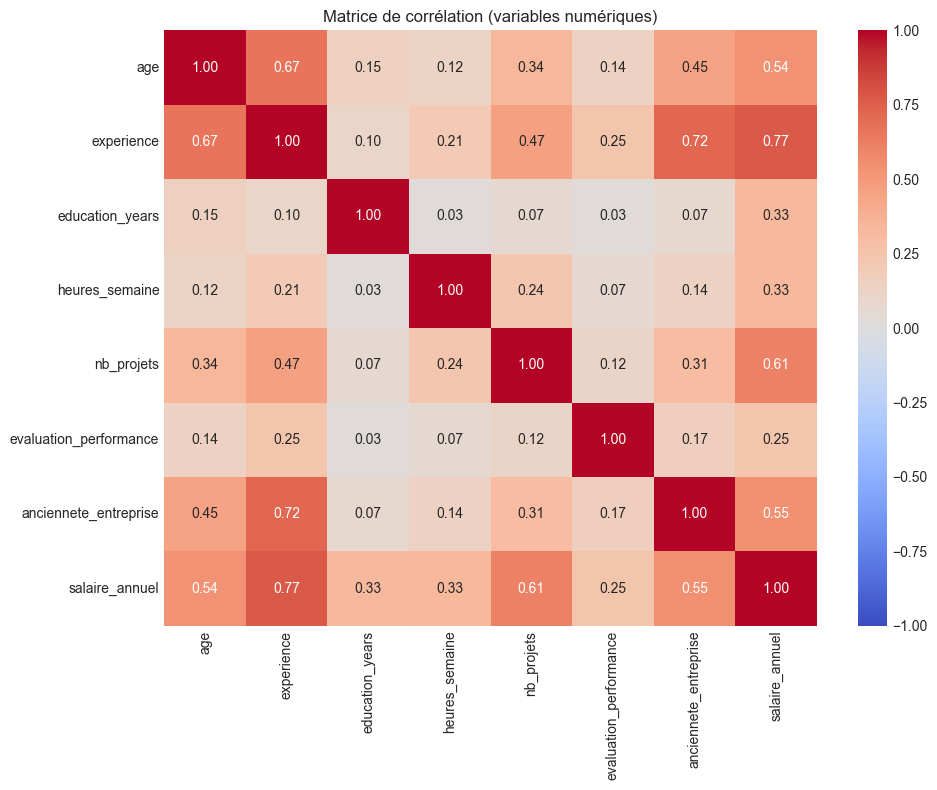

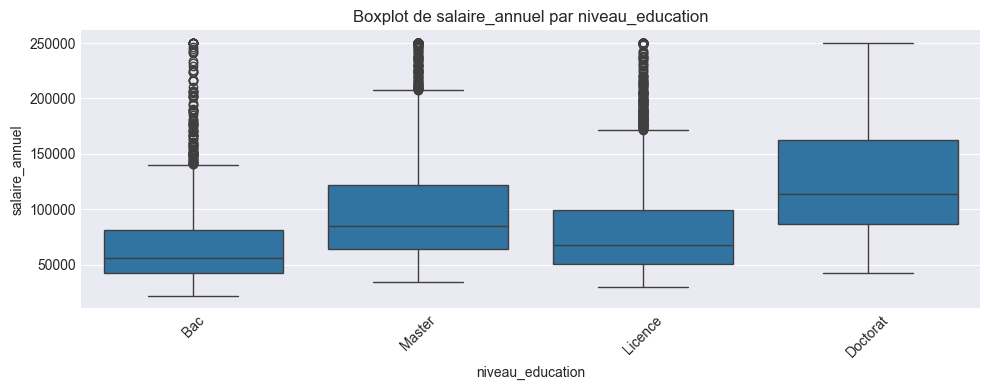

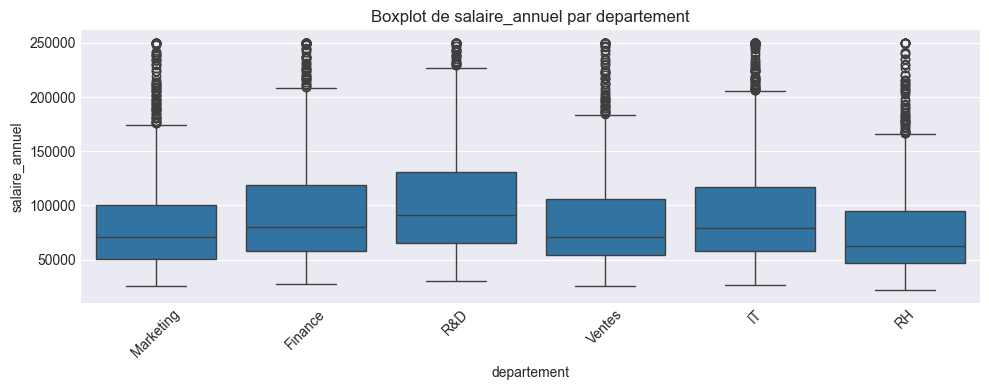

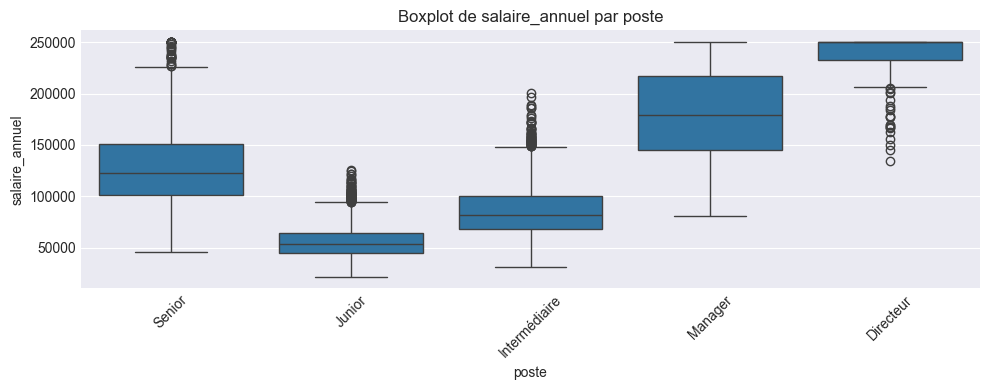

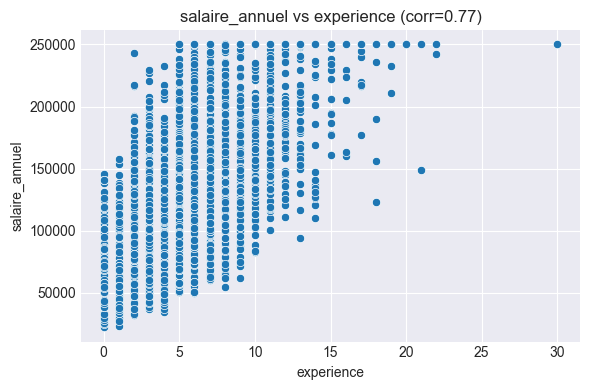

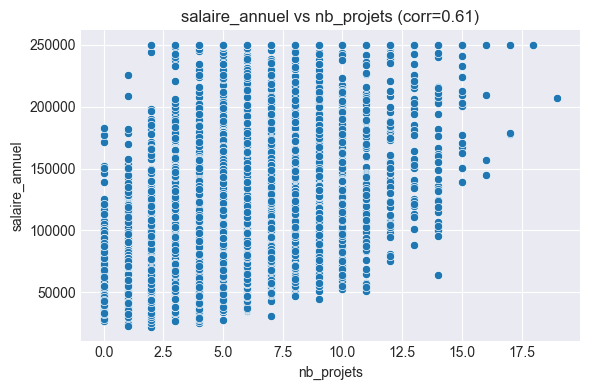

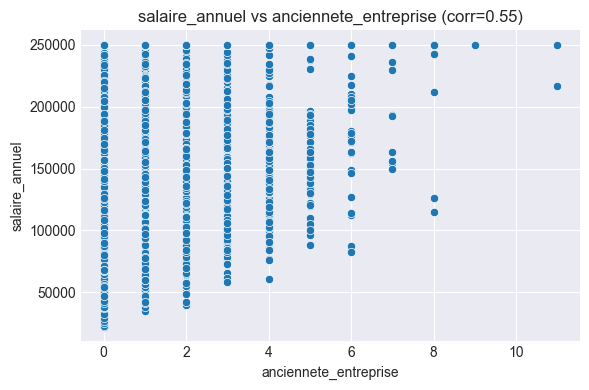

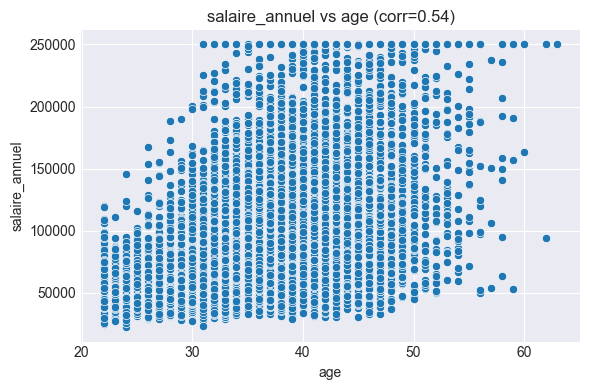

In [28]:
# Analyse des données

# TO DO : Analyser les données avec des visualisations appropriées (histogrammes, boxplots, heatmap de corrélation, etc.) 
# pour comprendre la distribution des variables et leurs relations avec la variable cible 'salaire'

# Détecter le nom de la cible (support 'salary' ou 'salaire')
target = 'salary' if 'salary' in df.columns else ('salaire' if 'salaire' in df.columns else df.columns[-1])

# Préparer listes de features numériques et catégorielles (numeric_cols et categorical_cols sont définies précédemment)
num_cols = [c for c in numeric_cols if c != target]
cat_cols = categorical_cols

# 1) Histogrammes pour les variables numériques (inclut la cible si numérique)
if len(num_cols) > 0:
    plt.figure(figsize=(12,8))
    df[[target] + num_cols].hist(bins=20, figsize=(12,8))
    plt.tight_layout()

# 2) Heatmap de corrélation (numérique)
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation (variables numériques)')
plt.tight_layout()

# 3) Boxplots du target par quelques variables catégorielles (si utiles)
for col in cat_cols[:3]:  # limiter à 3 pour la lisibilité
    if df[col].nunique() <= 20:  # éviter trop de modalités
        plt.figure(figsize=(10,4))
        sns.boxplot(x=col, y=target, data=df)
        plt.title(f'Boxplot de {target} par {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()

# 4) Scatter plots pour les variables numériques les plus corrélées avec la cible
if target in corr.columns:
    corrs = corr[target].drop(labels=[target], errors='ignore').abs().sort_values(ascending=False)
    top_feats = corrs.head(4).index.tolist()
    for feat in top_feats:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[feat], y=df[target])
        plt.title(f'{target} vs {feat} (corr={corrs[feat]:.2f})')
        plt.tight_layout()

# 5) Pairplot si le nombre de variables numériques est raisonnable
if len(num_cols) <= 5 and len(num_cols) > 0:
    sns.pairplot(df[[target] + num_cols].dropna(), diag_kind='kde')

## 2. Préparation des Données

### 2.1 Séparation des features et de la cible

In [6]:
# Séparation des features (X) et de la cible (y)

# Séparer les données en dataset de features (X) et dataset de cible (y)

In [7]:
# Division en ensemble d'entraînement et de test (80/20)

# Spliter les données en ensembles d'entraînement et de test (80/20) et utiliser l'arribut random_state=42 

### 2.2 Preprocessing Pipeline

Nous allons créer un pipeline de preprocessing qui:
1. Impute les valeurs manquantes pour les variables numériques
2. Applique le scaling sur les variables numériques
3. Applique le one-hot encoding sur les variables catégorielles

In [8]:
# TO DO : implémenter des stratégie de prétraitement des données numériques et catégorielles en utilisant ColumnTransformer et Pipeline

## 3. Modélisation

### 3.1 Modèle de Base - DummyRegressor

In [9]:
# TO DO : Entrainer un modèle DummyRegressor, qui servira de baseline, et évaluer ses performances sur l'ensemble de test

### 3.2 Régression Linéaire Simple

In [10]:
# TO DO : Entrainer un modèle de régression linaire

In [11]:
# TO DO : afficher les valeurs prédites par le modèle linéaire vs les valeurs réelles du dataset de test

In [12]:
# TO DO : afficher les valeurs des coefficients du modèle linéaire

## 4. Régularisation avec GridSearchCV

In [13]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 2, 20),
#    - 'selection': ['cyclic', 'random']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test 

In [14]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 3, 20),
#    - 'solver': ['auto', 'svd', 'cholesky', 'lsqr']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test

## 5. Résumé et Comparaison Finale

In [15]:
# TO : Afficher pour chaque modèle (dummy, linéaire, ridge, lasso) les performances sur l'ensemble d'entrainement et de test et conclure
# sur le choix du modèle et sa capacité de généralisation